# Example Code for the Non Linear Optimum Filter
-----
Import `qetpy` and other necessary packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qetpy as qp
from pprint import pprint

/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


## Use `QETpy` to generate some simulated TES noise

We can use `qetpy.sim.TESnoise` to help create a simulated PSD with characteristic TES parameters.

In [2]:
fs = 1.25e6
f = np.fft.fftfreq(32768, d=1/fs)
noisesim = qp.sim.TESnoise(r0=0.03)
psd_sim = noisesim.s_iload(freqs=f) + noisesim.s_ites(freqs=f) + noisesim.s_itfn(freqs=f)

f_fold, psd_sim_fold = qp.foldpsd(psd_sim, fs=fs)

<>:9: DeprecationWarning: invalid escape sequence \s
<>:9: DeprecationWarning: invalid escape sequence \s
<>:9: DeprecationWarning: invalid escape sequence \s
<ipython-input-3-057714a36901>:9: DeprecationWarning: invalid escape sequence \s
  ax.set_ylabel("PSD [A/$\sqrt{\mathrm{Hz}}$]")


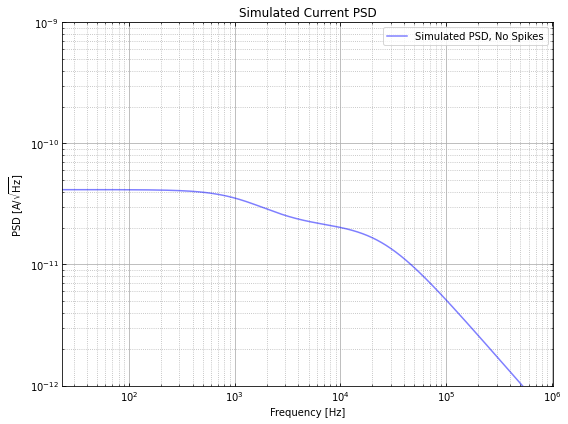

In [3]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.loglog(f_fold, psd_sim_fold**0.5, color="blue", alpha=0.5, label="Simulated PSD, No Spikes")
ax.set_ylim(1e-12,1e-9)
ax.grid()
ax.grid(which="minor", linestyle="dotted")
ax.tick_params(which="both", direction="in", right=True, top=True)
ax.legend(loc="best")
ax.set_title("Simulated Current PSD")
ax.set_ylabel("PSD [A/$\sqrt{\mathrm{Hz}}$]")
ax.set_xlabel("Frequency [Hz]")
fig.tight_layout()

With a PSD, we can use `qetpy.gen_noise` to generate random noise from the PSD (assuming the frequencies are uncorrelated). Then, we will create an example pulse.

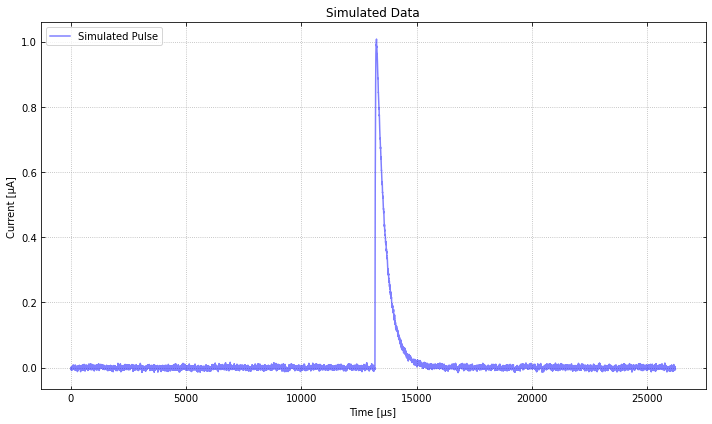

In [4]:
# create a template
pulse_amp = 1e-6 # [A]
tau_f = 400e-6 # [s]
tau_r = 20e-6 # [s]

t = np.arange(len(psd_sim))/fs

pulse = np.exp(-t/tau_f)-np.exp(-t/tau_r)
pulse_shifted = np.roll(pulse, len(t)//2)
template = pulse_shifted/pulse_shifted.max()

# use the PSD to create an example trace to fit
noise = qp.gen_noise(psd_sim, fs=fs, ntraces=1)[0]
signal = noise + np.roll(template, 100)*pulse_amp # note the shift we have added, 160 us



# plot 
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(t*1e6, signal*1e6, label="Simulated Pulse", color="blue", alpha=0.5)
ax.set_ylabel("Current [μA]")
ax.set_xlabel("Time [μs]")
ax.set_title("Simulated Data")
lgd = ax.legend(loc="upper left")
ax.tick_params(which="both", direction="in", right=True, top=True)
ax.grid(linestyle="dotted")
fig.tight_layout()

Let's use `qetpy.OFnonlin` to do the fit. To help visualize the fit, we will use the parameter `lgcplot=True` to plot the fit in frequency domain and time domain

In [5]:
qp.OFnonlin?

Init signature: qp.OFnonlin(psd, fs, template=None)
Docstring:     
This class provides the user with a non-linear optimum filter to
estimate the amplitude, rise time (optional), fall time, and time
offset of a pulse.

Attributes:
-----------
psd : ndarray
    The power spectral density corresponding to the pulses that
    will be used in the fit. Must be the full psd (positive and
    negative frequencies), and should be properly normalized to
    whatever units the pulses will be in.
fs : int or float
    The sample rate of the ADC
df : float
    The delta frequency
freqs : ndarray
    Array of frequencies corresponding to the psd
time : ndarray
    Array of time bins corresponding to the pulse
template : ndarray
    The time series pulse template to use as a guess for initial
    parameters
data : ndarray
    FFT of the pulse that will be used in the fit
lgcdouble : bool
    If False, only the Pulse hight, fall time, and time offset will
    be fit. If True, the rise time of the pul

In [7]:
qp.OFnonlin.dofit?

χ^2 = 1.0157


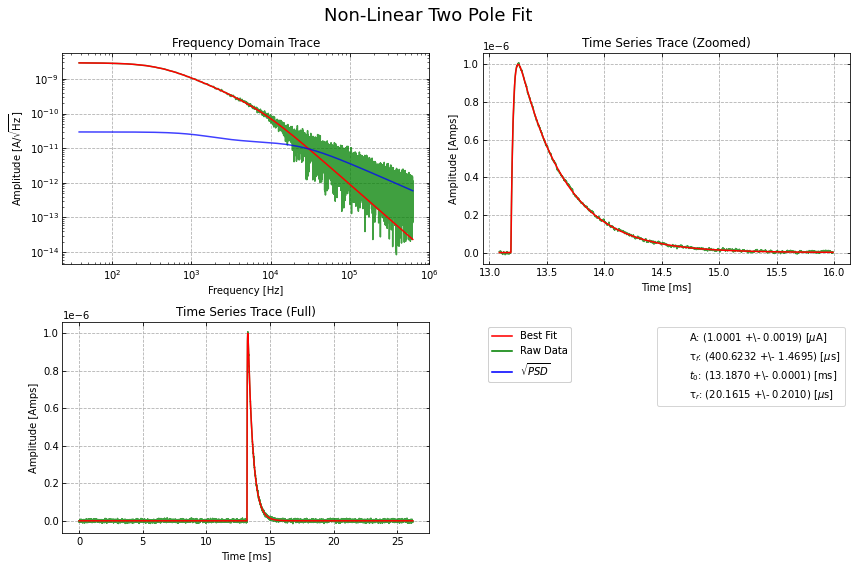

In [6]:
nonlinof = qp.OFnonlin(psd_sim, fs, template=None)
params_2poles, error, _, chi2_2poles, success = nonlinof.dofit(signal, npolefit=2, lgcplot=True)

print(f"χ^2 = {chi2_2poles:.4f}")

## Advance fit:  Fixing parameters, initial guess, bounds

More arguments can be given to `dofit` such as 
(type qp.OFnonlin.dofit? for full list)

 * guess: 1D numpy array with initial guessed value (if None, then used internally calculated guess). Array should be same length as number of fit parameters
 * bounds: 2-tupe of numpy array with lower and upper bounds
 * lgcfix: 1D numpy array (boolean). If True, fix parameter
 
For the above numpy array parameters, **order of the parameters** is as follow (see fit functions above)
 * 1-pole fit: (A, taufall1, t0)  (taurise arugment required)
 * 2-poles fit: (A, taurise, taufall1, t0)
 * 3-poles fit: (A, B, taurise, taufall1, taufall2, t0)
 * 4-poles fit: (A, B, C, taurise, taufall1, taufall2, taufall3, t0)


χ^2 = 0.9982


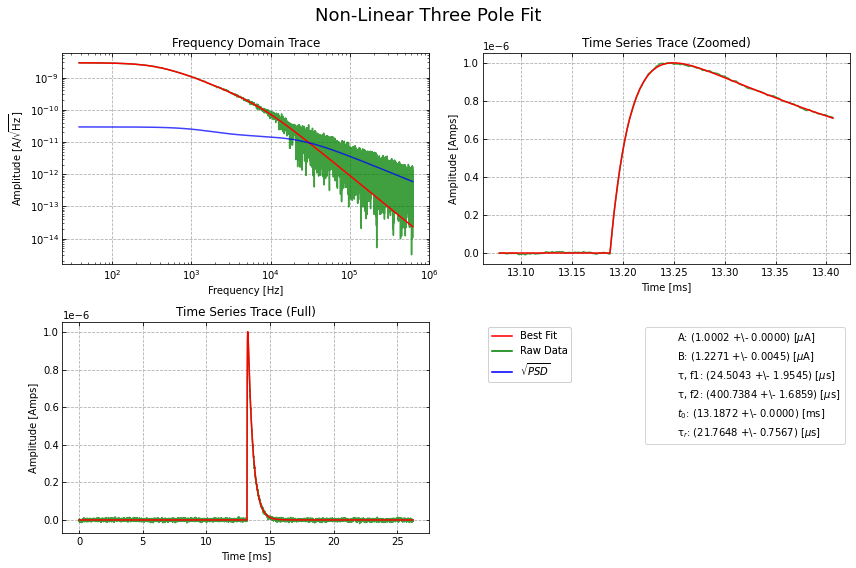

In [9]:
# let's do a 3-pole fit, fixing A and dt0 from 2-pole aboe
guess = np.array([params_2poles[0], None,None,None,None, params_2poles[3]])
lgcfix = np.array([True, False, False,False, False, True])

params_3poles, error, _, chi2_3poles, success = nonlinof.dofit(signal, guess=guess, 
                                                               lgcfix=lgcfix, npolefit=3, lgcplot=True)

print(f"χ^2 = {chi2_3poles:.4f}")